In [3]:
import torch
from torch.nn import ReLU

from unet.multitask_unet import UNet_Multitask
from dataloader import * 
from experiments.experiment_unet_multitask import *
from misc_functions import (convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency)
from feature_vis import GuidedBackprop
from factory import *
import yaml
from os import listdir
from experiment import Experiment

In [17]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model, layer):
        self.model = model
        self.gradients = None
        self.layer = layer
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        self.layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.encoder._modules.items():
            for n, layer in module._modules.items():
#                 print('pos: ', pos, ' module: ', module)
                if isinstance(layer, ReLU):
                    layer.register_backward_hook(relu_backward_hook_function)
                    layer.register_forward_hook(relu_forward_hook_function)

        for pos, module in self.model.aspp._modules.items():
            for n, layer in module._modules.items():
                if isinstance(layer, ReLU):
                    layer.register_backward_hook(relu_backward_hook_function)
                    layer.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class, depth_bp=True, class_nb=None):
        # Forward pass
        model_output, model_output_depth = self.model(input_image)
        print(model_output_depth)
        # Zero gradients
        self.model.zero_grad()
        # Backward pass
        if depth_bp:
            model_output_depth.backward(gradient=target_class)
        else:
            if len(model_output.size()) < 4:
                model_output = torch.unsqueeze(model_output, 0)
            pred = model_output[:,class_nb,:,:]
            pred.backward(gradient=target_class)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [5]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

exp_name = "shared_decoder_naive"
version = '0.9'
path = './experiment_data/' + exp_name + '/v_' + version
exp_config_path = path + '/' + 'hparams.yaml'
with open(exp_config_path) as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
hparams = dict_to_args(config_dict)


In [6]:
model = select_model(hparams)

# pretrained_model = UNet_Multitask_lightning(hparams, 3, 40 + 1)
# PATH = './experiment_unet_multitask/v_03/checkpoints/epoch=0-step=571.ckpt' #change checkpoint if necessary
# checkpoint = torch.load(PATH, map_location=torch.device(device))

In [7]:
chkpts = listdir(path + '/checkpoints/')
chkpt_path = path + '/checkpoints/' + chkpts[0]
checkpoint = torch.load(chkpt_path, map_location=torch.device(device))

In [8]:
pretrained_model = Experiment.load_from_checkpoint(chkpt_path, hparams=hparams)
pretrained_model = pretrained_model.to(device)

In [97]:
trainer = pl.Trainer(
    fast_dev_run=False,
    gpus=1,
    max_epochs=hparams.num_epochs,
    progress_bar_refresh_rate=False,
)
# trainer.fit(exp)
trainer.test(pretrained_model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8634231686592102,
 'test_log10_err': 0.07624257355928421,
 'test_loss': 0.5866230726242065,
 'test_mIoU': 0.7596863508224487,
 'test_rel_err': 0.21089473366737366,
 'test_rms_err': 4.536896705627441}
--------------------------------------------------------------------------------


/home/s1bhavsa/.local/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


[{'test_loss': 0.5866230726242065,
  'test_rel_err': 0.21089473366737366,
  'test_rms_err': 4.536896705627441,
  'test_log10_err': 0.07624257355928421,
  'test_mIoU': 0.7596863508224487,
  'test_acc': 0.8634231686592102}]

experiment.Experiment

In [47]:
dir(pretrained_model)

['CHECKPOINT_HYPER_PARAMS_KEY',
 'CHECKPOINT_HYPER_PARAMS_NAME',
 'CHECKPOINT_HYPER_PARAMS_TYPE',
 'T_destination',
 '_DeviceDtypeModuleMixin__update_properties',
 '_LightningModule__auto_choose_log_on_epoch',
 '_LightningModule__auto_choose_log_on_step',
 '_LightningModule__get_hparams_assignment_variable',
 '__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__jit_unused_properties__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_apply',
 '_apply_batch_transfer_handler',
 '_auto_collect_arguments',
 '_automatic_optimization',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_current_dataloader_i

In [9]:
modules = pretrained_model._modules
modules

OrderedDict([('model',
              DeeplabMultiTaskSharedDecoder(
                (encoder): Encoder(
                  (preprocess): Sequential(
                    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    (2): ReLU(inplace=True)
                    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                  )
                  (layer1): Sequential(
                    (0): Bottleneck(
                      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [10]:
deeplab_first_layer = pretrained_model.model.encoder.preprocess._modules['0']
deeplab_first_layer

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [11]:
test_csv = "data/test_data.csv"
test_data = HypersimDataset(csv_file=test_csv, data_path = "./data/")
test_loader = DataLoader(test_data, batch_size=1,num_workers=0, shuffle=True)

In [12]:
prep_img, depth, semseg = next(iter(test_loader))
prep_img = prep_img.to(device)
depth = depth.to(device)
semseg = semseg.to(device)
file_name_to_export = './'
prep_img.requires_grad = True 


/home/s1bhavsa/.local/lib/python3.7/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


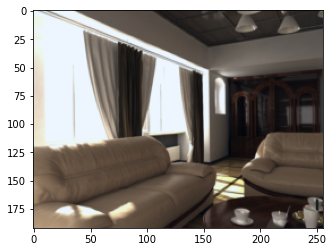

In [13]:
import matplotlib.pyplot as plt
ex_img = prep_img[0, :, :, :] - prep_img[0, :, :, :].min()
ex_img = ex_img/ex_img.max()
# plt.imshow(prep_img.detach().numpy().squeeze().transpose([1,2,0]))
plt.imshow(ex_img.detach().numpy().transpose([1,2,0]))

In [18]:
# Guided backprop
GBP = GuidedBackprop(pretrained_model.model, deeplab_first_layer)
# Get gradients for depth 
guided_grads = GBP.generate_gradients(prep_img, depth.squeeze())
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')

tensor([[3.6679, 3.7911, 3.9144,  ..., 4.6728, 4.5501, 4.4273],
        [3.7512, 3.8637, 3.9762,  ..., 4.7654, 4.6526, 4.5398],
        [3.8345, 3.9363, 4.0380,  ..., 4.8580, 4.7551, 4.6522],
        ...,
        [1.3163, 1.3548, 1.3933,  ..., 1.7092, 1.7125, 1.7158],
        [1.3015, 1.3345, 1.3675,  ..., 1.6511, 1.6445, 1.6379],
        [1.2866, 1.3141, 1.3417,  ..., 1.5930, 1.5765, 1.5600]],
       grad_fn=<SqueezeBackward0>)


TypeError: Cannot handle this data type

In [15]:
GBP = GuidedBackprop(pretrained_model.model, deeplab_first_layer)
##### get gradient for segmentation for most occurring class
unique, counts = torch.unique(semseg, sorted=True, return_counts=True)
max_idx = torch.argmax(counts)
class_nb = unique[max_idx]
guided_grads = GBP.generate_gradients(prep_img, semseg, depth_bp=False, class_nb=class_nb)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color_seg')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray_seg')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal_seg')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal_seg')

Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(18, 18), dilation=(18, 18), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
AdaptiveAvgPool2d(output_size=1)
Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(1280, 256, kernel_size=(1, 1

In [19]:
chkpt_path

'./experiment_data/shared_decoder_naive/v_0.9/checkpoints/epoch=44-step=16109.ckpt'